In [387]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from ipywidgets import interact
import networkx as nx
import pandas as pd
import random
import matplotlib.pyplot as plt
from copy import deepcopy
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from networkx.classes.function import *
import matplotlib.pyplot as plt

# ODE-based Simulation Model
To model the spreading of the epidemic disease, ordinary differential equation models have been used. There are several kinds of models including SIR, SIS, SEIR and SEIRS, where each particular letter stands for one of the groups of the whole population (Susceptible, Infective, Exposed and Recovered), and the time evolution of these groups is modeled by the set of differential equations with several parameters as external factors.

To take a look into the ODE-based simulation model, we start at the basic SEIR model to model the dynamics of the number of four different kinds of people.

## 1. Simple SEIR model
The time evolution of the population compartments in ODE model is described by several nonlinear differential equations. For instance, the basic SEIR model can be written as several equations:

$$\frac{d S}{d t} =\mu(N-S)-\beta \frac{S I}{N}$$

$$\frac{d E}{d t} =\beta \frac{S I}{N}-(\mu+\sigma) E$$

$$\frac{d I}{d t} =\sigma E-(\mu+\gamma) I$$

$$\frac{d R}{d t} =\gamma I-\mu R$$
where $S, E, I, R$ stands for the *Susceptible*, *Exposed*, *Infected*, *Recovered* people respectively. 

- $N = S+E+I+R$ is the total number of population, 
- $\beta$ controls how often a susceptible-infected contact results in a new exposure, 
- $\gamma$ is	the rate an infected recovers and moves into the resistant phase, 
- $\sigma$ is the rate an exposed person becomes infective, 
- $\mu$ is the natural mortality rate (unrelated to disease).

In [388]:
def seir_base_simulation(N = 1000, 
                         I0 = 5, 
                         R0 = 0, 
                         E0 = 5, 
                         beta = 0.8, 
                         gamma = 0.1, 
                         sigma = 0.3, 
                         mu = 0.0001, 
                         t = 100):

    # Total population, N.
    #N = N
    # Initial number of infected and recovered individuals, I0 and R0.
    #I0, R0 = 1, 0
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0 - E0
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    # A grid of time points (in days)
    t = np.linspace(0, t, t)

    # The SIR model differential equations.
    def deriv(y, t, N, beta, gamma, sigma, mu):
        S, E, I, R = y
        beta = beta # * np.exp(-t/50)
        dSdt = mu * (N - S) - beta * S * I / N
        dEdt = beta * S * I / N - (mu + sigma) * E
        dIdt = sigma * E - (mu + gamma) * I
        dRdt = gamma * I - mu * R
        return dSdt, dEdt, dIdt, dRdt

    # Initial conditions vector
    y0 = S0, E0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, sigma, mu))
    S, E, I, R = ret.T

    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure(facecolor='w', figsize = [9, 6])
    ax = fig.add_subplot(111,  axisbelow=True)
    ax.plot(t, S/N, 'b', alpha=0.6, lw=2.5, label='Susceptible')
    ax.plot(t, E/N, 'purple', alpha=0.6, lw=2.5, label='Exposed')
    ax.plot(t, I/N, 'r', alpha=0.6, lw=2.5, label='Infected')
    ax.plot(t, R/N, 'g', alpha=0.6, lw=2.5, label='Recovered')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Ratio of people')
    ax.set_ylim(0,1.1)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major',  c='grey',lw=1, ls=':')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

# Simulation with interaction.
By changing different values on different parameters, the shape of curve will be different.

In [389]:
interact (seir_base_simulation
    , N=(1, 1000, 1)
    , I0=(1, 50, 1)
    , E0=(0, 100,1)
    , beta=(0, 1, 0.05)
    , gamma = (0, 0.5, 0.01)
    , sigma = (0, 1, 0.05)
    , mu = (0, 0.01, 0.001)
    , t = (0, 300, 10)
    );


interactive(children=(IntSlider(value=1000, description='N', max=1000, min=1), IntSlider(value=5, description=…

# 2. More Complex Model: SIRS model with Quarantine
Apart from the existing modules in SIRS model, we also considers the effect of self-quaratine, the infected/exposed people will stay at home to avoid interacting with others.
Specifically, we add to extra parameter $Q_E$, $Q_I$ which stand for the number of exposed/infected population being quarantined respectively. Then, the ODE formula can be expressed as 
$$\frac{d S}{d t} =\mu(N-S)-\beta \frac{S I}{N}$$

$$\frac{d E}{d t} =\beta \frac{S I}{N}-(\mu+\sigma+q) E$$

$$\frac{d I}{d t} =\sigma E-(\mu+\gamma+q) I$$

$$\frac{d R}{d t} =\gamma (I+Q_I)-\mu R$$

$$\frac{d Q_E}{d t} =- \sigma  Q_E + q  E$$

$$\frac{d Q_I}{d t} =- \gamma  Q_I + \sigma Q_E + q I$$

- $q$ is the proportion of population being self-quarantined.

In [390]:
def seir_add_simulation(N = 1000, 
                         I0 = 1, 
                         R0 = 0, 
                         E0 = 0, 
                         beta = 0.8, 
                         gamma = 0.1, 
                         sigma = 0.3, 
                         mu = 0.0001, 
                         q = 0.05,
                         t = 100):

    # Total population, N.
    #N = N
    # Initial number of infected and recovered individuals, I0 and R0.
    #I0, R0 = 1, 0
    # Everyone else, S0, is susceptible to infection initially.
    QE0, QI0 = 0, 0
    S0 = N - I0 - R0 - E0 - QE0 - QI0
    
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    # A grid of time points (in days)
    t = np.linspace(0, t, t)

    # The SIR model differential equations.
    def deriv(y, t, N, beta, gamma, sigma, mu, q):
        S, E, I, QE, QI, R = y
        dSdt = mu * (N - S) -beta * S * I / N
        dEdt = beta * S * I / N - (mu + sigma + q) * E
        dIdt = sigma * E - (mu + gamma + q) * I
        dRdt = gamma * I - mu * R + gamma * QI
        dQEdt = - sigma * QE + q * E
        dQIdt = - gamma * QI + sigma * QE + q * I
        return dSdt, dEdt, dIdt, dQEdt, dQIdt, dRdt

    # Initial conditions vector
    y0 = S0, E0, I0, QE0, QI0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, sigma, mu, q))
    S, E, I, QE, QI, R = ret.T

    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure(facecolor='w', figsize = [9, 6])
    ax = fig.add_subplot(111,  axisbelow=True)
    ax.plot(t, S/N, 'b', alpha=0.6, lw=2.5, label='Susceptible')
    ax.plot(t, (E+QE)/N, 'purple', alpha=0.6, lw=2.5, label='Exposed')
    ax.plot(t, (I+QI)/N, 'r', alpha=0.6, lw=2.5, label='Infected')
    ax.plot(t, R/N, 'g', alpha=0.6, lw=2.5, label='Recovered')
    #ax.plot(t, QE/N, 'hotpink', alpha=0.6, lw=2.5, label='Recovered')
    #ax.plot(t, QI/N, 'orange', alpha=0.6, lw=2.5, label='Recovered')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Ratio of people')
    ax.set_ylim(0,1.1)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major',  c='grey',lw=1, ls=':')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

Simulation with interaction.
By changing different values on different parameters, the shape of curve will be different.
Compare our model with different $q$, it is clear that quarantine will reduce the total proportion of infected population.

In [391]:
interact (seir_add_simulation
    , N=(1, 1000, 1)
    , I0=(1, 50, 1)
    , E0=(0, 100,1)
    , beta=(0, 1, 0.05)
    , gamma = (0, 0.5, 0.01)
    , sigma = (0, 1, 0.05)
    , mu = (0, 0.01, 0.001)
    , q = (0, 1, 0.05)
    , t = (0, 300, 10)
    );


interactive(children=(IntSlider(value=1000, description='N', max=1000, min=1), IntSlider(value=1, description=…

# 3. More Complicated Case: Modeling the spread of the disease in meta-population level
The basic SEIR model (introduced in part 1) implicitly assumes a homogeneous infection network between individuals and thus can only model epidemic propagation in a single population. Here, we extend the SIR model to the metapopulation scenario.

## Model Description
A **metapopulation** refers a group of separated sub-populations which interact at some level. For instance, we can model each city in USA as a sub-population, and all cities in USA together as a metapopulation. Therefore, apart from learning the dynamics in each small sub-populations, we can better model the population flows between different regions and capture the dynamic patterns on disease spreading.

Specifically, in our problem, given a meta-population with $N$ sub-populations, we denote the total number of individuals in sub-population $n$ as $P_n$ , and the numbers of individuals in the $S$, $E$, $I$, $R$ states at time t as $s_n$, $e_n$, $i_n$, $r_n$, respectively. Between sub-populations $n$ and $m$, we define the interaction strength as $h_{nm}$, which is the average volume of visitors from $n$ to $m$ in a unit time.

## Graph Construction
To better model the dynamic of populations, i.e. $h_{nm}$, we can build a weighted graph $G=(V,E)$ over the $n$ sub-populations. Here $V$ is the set of nodes which corresponds to $n$ sub-populations, i.e. $|V|=n$. $E$ is the edge sets, and for each edge $e = (m, n) \in E$, there is a weight $w = h_{m n}$ that control the strength of the population flows between the nodes.
Our model is graph-agnostic and can be applied to graphs with arbitrary size.

To begin with, we adopt the similar topology of the graph studied in the previous part. Here we use Connected Cavemen Graph, which is a ring of cliques as an example. We can run the following code multiple times to generate a good layout.

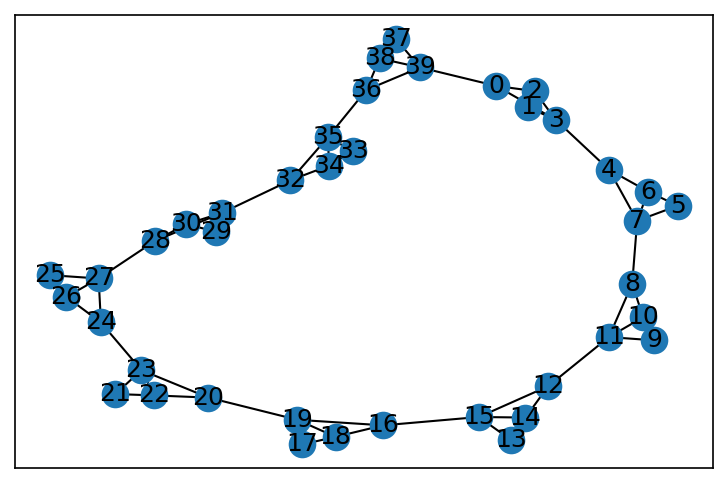

In [392]:
from networkx.linalg.graphmatrix import *
l = 10 # (int) – number of cliques
k = 4 # (int) – size of cliques
G = nx.generators.community.connected_caveman_graph(l, k) ## 
ccg_pos = nx.layout.spring_layout(G)
plt.figure(dpi =150)
nx.draw_networkx(ccg, node_size=150, pos=ccg_pos)
plt.show()
A = adjacency_matrix(G).toarray() # adjacency matrix of the graph

## Modeling population flows
To model the mobility among different sub-populations, we need to simulate the population flow among them. In graph perspective, these can be regarded as the flow between different edge pairs. To calculate the population flow, there are several ways:
- If the real life mobility data is availble, then we can use the corresponding real data to calculate the flow matrix $H$ for simulation. 
- In many cases, if the real data is unavailable, then we can also do some simulations based on random walk theory on graphs.

Here, since it is difficult to collect the real-life mobility flow data, we aim to simulate the mobility based on node degree. Specifically, given a graph $G$ with the adjacency matrix $A$, the ratio of the flow population from node $m$ to $n$ is in proportion to the node degree $d_m$, i.e. $\frac{h_{m n}}{p_m} \propto \frac{1}{d_{m}}$. In this case, we consider each neighbor nodes as homogeneous and can formally write the transition as 

$$\hat{A} = D^{-1}A$$
$$H = (1-\delta) I +  \delta \hat{A}$$

where $D=\text{diag}(d_1, d_2, ..., d_N)$ denotes the degree for each node, $A$ is the adjacency matrix of the graph $V$, $\delta$ is a parameter that controls the strength of the flow, and $h$ is the transition ratio matrix that determine *the proportion of* population among different sub-populations. 

Also, we can consider the symmetric case where the the ratio of the flow population from node $m$ to $n$ is in related to both the degree of node $m$ and $n$, as $1/\sqrt{d_md_n}$, i.e. $\frac{h_{m n}}{p_m} \propto \frac{1}{\sqrt{d_md_n}}$. In this case, we can formally write the transition as 

$$\hat{A} = D^{-1/2}AD^{-1/2}$$
$$H = \text{normalize}\left((1-\delta) I +  \delta \hat{A}\right)$$

Here we need to normalize $H$ since the original sum of $h$ for each row is not equal to 1. Note that $H_{mn} = h_{mn}/P_{m}$.

In [393]:
def normalized_adjacency(A, symmetry = False):
    if symmetry:
        x = np.diag(1/np.sqrt(np.sum(A, axis = 0)))
        y = (x).dot(A).dot(x)
        z = np.diag(1/np.sum(y, axis = 0))
        return z.dot(y)
        
    else:
        x = np.diag(1/np.sum(A, axis = 0))
        return x.dot(A)

A_hat = normalized_adjacency(A, symmetry = False)
print('normalized matrix:', A_hat)
print('sum of each row (should be 1):', np.sum(A_hat, axis = 1)) # check that every row of A sum to 1

normalized matrix: [[0.         0.         0.33333333 ... 0.         0.         0.33333333]
 [0.         0.         0.5        ... 0.         0.         0.        ]
 [0.33333333 0.33333333 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.5        0.5       ]
 [0.         0.         0.         ... 0.33333333 0.         0.33333333]
 [0.25       0.         0.         ... 0.25       0.25       0.        ]]
sum of each row (should be 1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Calculating Mobility Flows
Then, in a metapopulation, a susceptible individual of sub-population $n$ may contact with infectious individuals from several sources:

- the infectious *in the same sub-population* with a total number of $i_n$, which will result in $$\beta \cdot s_{n} \cdot i_{n}$$ new infectious in $n$-th subpopulation where $\beta$ is the infection rate; 
- the infectious visitors *from other sub-populations*. The probability for an individual in $m$ visiting $n$ can be estimated by $h_{mn}/P_{m}$, so the new infectious in $n$ totals $$\beta \cdot s_{n} \sum_{m \in \mathcal{N}_n}\left(h_{m n} / P_{m}\right) i_{m}$$ where $\mathcal{N}_n$ is the neighborhood of $n$.

Also, since for each sub-population, there exists several people that come to other sub-populations, then the probability for an individual in $m$ visiting $n$ can be estimated by $h_{mn}/P_{m}$, so the new infectious from $n$ totals $$\beta \cdot \sum_{m \in \mathcal{N}_n}\left(h_{n m} / P_{n}\right) i_{n}$$ where $\mathcal{N}_n$ is the neighborhood of $n$.

Then, to sum up, the total number of new exposures from sub-population $n$ caused by the three types of contacts is 
$$\beta \cdot s_{n} \sum_{m \in \mathcal{N}_n}  \left(h_{m n}/ P_{m} - h_{n m} / P_{n}\right) i_{m} + \beta s_n \cdot i_n $$

Since we also need to consider the dynamic sub-populations, then we need to first calculate the population after flow transition as $s_n^{'} = \sum_{m}\frac{h_{m n}}{P_{m}}s_{m}$, $e_n^{'} = \sum_{m}\frac{h_{m n}}{P_{m}}e_{m}$, $i_n^{'} = \sum_{m}\frac{h_{m n}}{P_{m}}i_{m}$, $r_n^{'} = \sum_{m}\frac{h_{m n}}{P_{m}}r_{m}$. 
Note that $h_{nn}/P_n = 1 - \sum_{m \in \mathcal{N}_n} h_{n m}/ P_{n}$, 
then, from the above analysis, we can rewrite the dynamic relationship of $s_n, e_n , i_n, r_n$ as

$$ \frac{\mathrm{d} s_{n}}{\mathrm{d} t}=\mu(P_n - s'_n)- \beta s'_n \cdot i'_n $$

$$ \frac{\mathrm{d} e_{n}}{\mathrm{d} t} =\beta s'_n \cdot i'_n -(\mu + \sigma) e'_n $$

$$ \frac{\mathrm{d} i_{n}}{\mathrm{d} t} =\sigma \cdot e'_{n} - (\mu + \gamma) i'_n $$

$$ \frac{\mathrm{d} r_{n}}{\mathrm{d} t} =\gamma \cdot i'_{n} - \mu \cdot r'_n $$
where $s_n, e_n, i_n, r_n$ stands for the *Susceptible*, *Exposed*, *Infected*, *Recovered* people for sub-population $n$ respectively. 
- $P_n = s'_n+e'_n+i'_n+r'_n$ is the total number of population, 
- $\beta$ controls how often a susceptible-infected contact results in a new exposure, 
- $\gamma$ is	the rate an infected recovers and moves into the resistant phase, 
- $\sigma$ is the rate an exposed person becomes infective, 
- $\mu$ is the natural mortality rate (unrelated to disease).

Note that the form of the ODE equation is very similar to the previous sub-population level, this is mainly due to the population mobility can be formulated as the 'biased random walk' on neighbors, and such walk can be modeled via a transition matrix from the analysis above. Actually the whole system now is more complicated and need to consider the dynamics for all sub-populations together.

## Simulation Steps
For simulation the spread of the disease, we assume that the total population for each sub-population is the same for simplicity (but it surely can be changed), and the virus appears on sub-population #0. 
For different parameters, we add several assumptions which make sense under the real scenarios. Specifically, for parameter $\gamma$, we add a more strong assumtion that it varies with time. This is mainly because with the passage of the time, people get more aware of the disease and more powerful medication is likely to be introduced. Therefore, people can get better treatment and is easier to recover from the disease.
In our experiments, we just use the linear function to model the relation between $\gamma$ and $t$. Specifically, let the initial $\gamma$ be $\gamma_0$, then the $\gamma$ can be written as $$\gamma_t = \gamma_0(1 + \alpha t)$$
where $\alpha$ is a parameter controlling the increase speed of $\gamma$. Then, below is a simple case with $N = 1000$, $\alpha= 0.001$, $\beta= 0.8$, $\gamma_0=0.1$, $\sigma=0.5$, $\mu = 0.0001$, $\delta=0.8$.

Input shape [should be 160]: (160,)
Output shape [should be (160, 200)]: (160, 200)


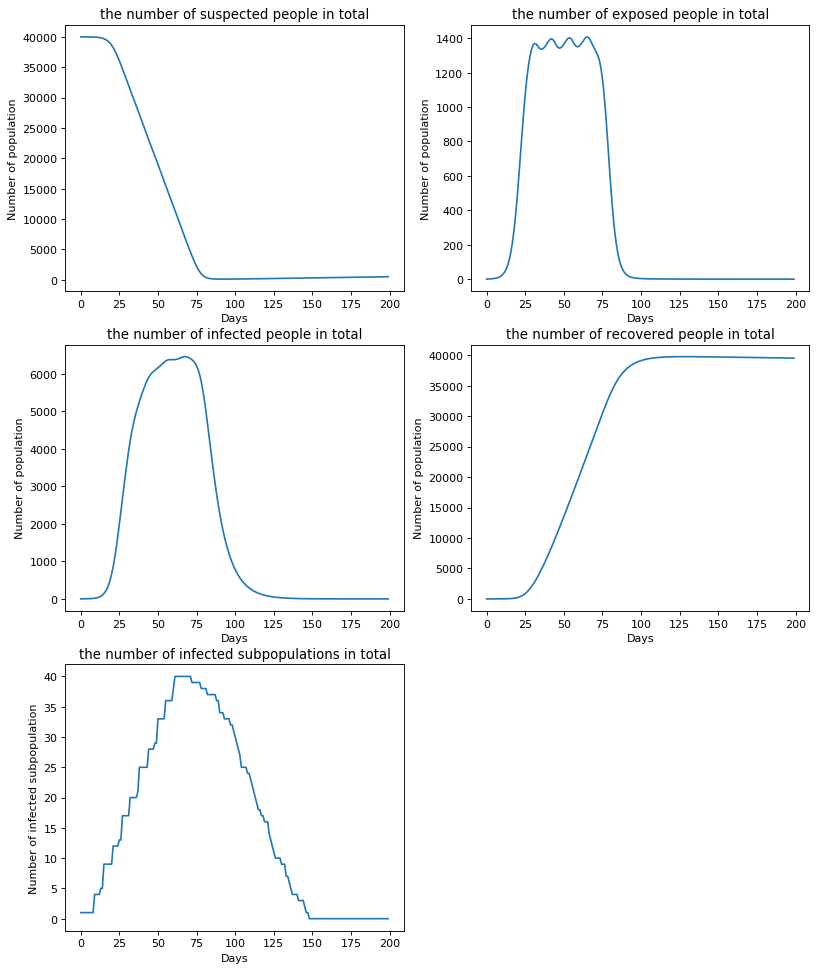

In [394]:
N = 1000 # number of sub-population
M = A_hat.shape[0] # number of sub-populations
I0 = np.zeros(M)#np.random.randint(size = M, low=10, high = 30) #0
I0[0] = 1
R0 = np.zeros(M)  #0 
E0 = np.zeros(M) #0 
beta = 0.8 
gamma = 0.1 
sigma = 0.5 
mu = 0.0001 
T = 200
delta = 0.9
alpha = 0.001
A = np.eye(M) * delta + A_hat * (1-delta)
# Everyone else, S0, is susceptible to infection initially.
# QE0, QI0 = np.zeros(M), np.zeros(M) #0, 0
S0 = N - I0 - R0 - E0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
# A grid of time points (in days)
t = np.linspace(0, T, T)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma, sigma, mu, q, A):
    y = y.reshape(4, -1)
    
    S, E, I, R = y[0], y[1], y[2], y[3] # S, E, I, R: array with shape (M, )
    #print(S.shape,E,I,R)
    S = A.T.dot(S)
    E = A.T.dot(E)
    I = A.T.dot(I)
    R = A.T.dot(R)
    N = S + E + I + R
    gamma2 = gamma * (1 + t * alpha)
    dSdt = mu * (N - S) - beta * S * I / N
    dEdt = beta * S * I / N - (mu + sigma) * E
    dIdt = sigma * E - (mu + gamma2) * I
    dRdt = gamma2 * I - mu * R
    return np.hstack([dSdt, dEdt, dIdt, dRdt])
    #return dSdt, dEdt, dIdt, dRdt 

# Initial conditions vector
y0 = np.hstack([S0, E0, I0,  R0])
print('Input shape [should be %d]:'%(4*M), y0.shape)
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, sigma, mu, q, A))

ret = ret.T
print('Output shape [should be (%d, %d)]:'%(4*M, T), ret.shape)

S = ret[ : M]
E = ret[M : 2*M]
I = ret[2*M : 3*M]
R = ret[3*M : 4*M]
#S, E, I, R = ret.T

num_of_infected_sub_population = []
for i in range(T):
    num_of_infected_sub_population.append(len([x for x in I[:, i] if int(x) >= 1]))
    
plt.figure(figsize = [12,15], dpi = 80)
plt.subplot(3,2,1)
plt.plot(np.sum(S, axis = 0))
plt.xlabel('Days')
plt.ylabel('Number of population')
plt.title('the number of suspected people in total')
plt.subplot(3,2,2)
plt.plot(np.sum(E, axis = 0))
plt.xlabel('Days')
plt.ylabel('Number of population')
plt.title('the number of exposed people in total')
plt.subplot(3,2,3)
plt.plot(np.sum(I, axis = 0))
plt.xlabel('Days')
plt.ylabel('Number of population')
plt.title('the number of infected people in total')
plt.subplot(3,2,4)
plt.plot(np.sum(R, axis = 0))
plt.xlabel('Days')
plt.ylabel('Number of population')
plt.title('the number of recovered people in total')
plt.subplot(3,2,5)
plt.plot(num_of_infected_sub_population)
plt.xlabel('Days')
plt.ylabel('Number of infected subpopulation')
plt.title('the number of infected subpopulations in total')
plt.show()


## Analysis
From the above analysis, we can see that the dynamics differs quit a lot for different $\delta$. For instance, with the higher $\delta$, the spread of the disease will slower, and the peak number of infected people will be smaller. Moreover, the number of the infected subpopulations will also increase a bit slower. These phenomenons indicates that by reducing the travel among different sub-populations, the disease will be better controlled.

## Modeling with interactions
To better illustrate the effect of different parameters, we try to build a GUI interface to simulate it from both macro and micro perspectives. By switching over 'target', you can choose the number of population that you would like to visualize.
### Macro Perspective:
We observe the total number of four kinds of population (S, E, I, R) and plot them in a figure.
### Micro Perspective:
We observe the number of four kinds of population (S, E, I, R) for each sub-population and plot them in a figure.

In [395]:
def seir_network_simulation(N = 1000, 
                         beta = 0.8, 
                         gamma0 = 0.1, 
                         sigma = 0.5,
                         alpha = 0.001,
                         mu = 0.0001, 
                         T = 200,
                         delta = 0.9,
                         target = 1):

    #N = 1000 # number of sub-population
    M = A_hat.shape[0] # number of sub-populations
    I0 = np.zeros(M) # np.random.randint(size = M, low=10, high = 30) #0
    I0[0] = 1
    R0 = np.zeros(M)  #0 
    E0 = np.zeros(M) #0 
    beta = 0.8 
    gamma = gamma0
    A = np.eye(M) * delta + A_hat * (1-delta)
    # Everyone else, S0, is susceptible to infection initially.
    # QE0, QI0 = np.zeros(M), np.zeros(M) #0, 0
    S0 = N - I0 - R0 - E0
    t = np.linspace(0, T, T)

    # The SIR model differential equations.
    def deriv(y, t, N, beta, gamma, sigma, mu, q, A):
        y = y.reshape(4, -1)

        S, E, I, R = y[0], y[1], y[2], y[3] # S, E, I, R: array with shape (M, )
        #print(S.shape,E,I,R)
        S = A.T.dot(S)
        E = A.T.dot(E)
        I = A.T.dot(I)
        R = A.T.dot(R)
        N = S + E + I + R
        gamma2 = gamma * (1+t*alpha)
        dSdt = mu * (N - S) - beta * S * I / N
        dEdt = beta * S * I / N - (mu + sigma) * E
        dIdt = sigma * E - (mu + gamma2) * I
        dRdt = gamma2 * I - mu * R
        return np.hstack([dSdt, dEdt, dIdt, dRdt])

    # Initial conditions vector
    y0 = np.hstack([S0, E0, I0,  R0])
    print('Input shape [should be %d]:'%(4*M), y0.shape)
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, sigma, mu, q, A))
    ret = ret.T
    print('Output shape [should be (%d, %d)]:'%(4*M, T), ret.shape)

    S = ret[ : M]
    E = ret[M : 2*M]
    I = ret[2*M : 3*M]
    R = ret[3*M : 4*M]
    
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure(facecolor='w', figsize =  [8,6], dpi = 100)
    ax = fig.add_subplot(111,  axisbelow=True)
    if target == "All":
        plt.plot(t, np.sum(S, axis = 0), 'b', alpha=0.6, lw=2.5, label='Susceptible')
        plt.plot(t, np.sum(E, axis = 0), 'purple', alpha=0.6, lw=2.5, label='Exposed')     
        plt.plot(t, np.sum(I, axis = 0), 'r', lw=2.5, label='Infected')
        plt.plot(t, np.sum(R, axis = 0), 'g', lw=2.5, label='Recovered')
        plt.title('Curve for all sub-populations')
    else:
        plt.plot(t, S[target], 'b', alpha=0.6, lw=2.5, label='Susceptible')
        plt.plot(t, E[target], 'purple', alpha=0.6, lw=2.5, label='Exposed')     
        plt.plot(t, I[target], 'r', lw=2.5, label='Infected')
        plt.plot(t, R[target], 'g', lw=2.5, label='Recovered')
        plt.title('Curve for sub-population %d'%target)
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number of people')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major',  c='grey',lw=1, ls=':')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    plt.show()

In [358]:
interact (seir_network_simulation
    , N=(1, 1000, 1)
    , beta=(0, 1, 0.05)
    , gamma0 = (0, 0.5, 0.01)
    , alpha = (0, 0.1, 0.001)
    , sigma = (0, 1, 0.05)
    , mu = (0, 0.01, 0.001)
    , T = (0, 300, 10)
    , delta = (0.6, 1, 0.05)
    , target = ["All"] + [i for i in range(A_hat.shape[0])]
    );


interactive(children=(IntSlider(value=1000, description='N', max=1000, min=1), FloatSlider(value=0.8, descript…

From the above visualization, it is clear that, for the nodes (i.e. subpopulations) near to the origin node (node #0), the peak number of infected people got higher, and the peak arrives early. This is mainly due to the graph structure, the propagation of virus takes some time. Also, with the passage of time, $\gamma$ increases, therefore the increase of the infected population will be slower, making the peak becomes lower for these distant nodes.

# Simulations on different random graphs
Apart from the small world graph, our method can also generalized to other types of social networks. One of the  random scale-free network is Barabasi-Albert graph, which is generated using a preferential attachment mechanism. 

Specifically, the Barabasi-Albert graph begins with an initial connected network of $l$ nodes.
New nodes are added to the graph one at a time. Each new node is connected to $k (k<l)$ existing nodes with a probability that is proportional to the number of links that the existing nodes already have. Formally, the probability that the new node $m$ is connected to node $n$ is
$$p_{n}=\frac{\text{deg}(n)}{\sum_{k} \text{deg}(k)}$$
where $\text{deg}(k)$ is the degree of node $k$ and the sum is made over all pre-existing nodes $k$. In this way, the  such kind of graphs have power-law (or scale-free) degree distributions, with the degree distribution 
$$P(k) \propto k^{-3}$$
Moreover, the average path length of the Barabasi-Albert graph increases approximately logarithmically with the size of the network as 
$$
\ell \sim \frac{\ln N}{\ln \ln N}
$$

In the simulation, we will try on different parameter $k$ and observe the properties of the disease spread.

**Reference**: https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model.

A sample barabasi albert graph with l = 20, k = 2


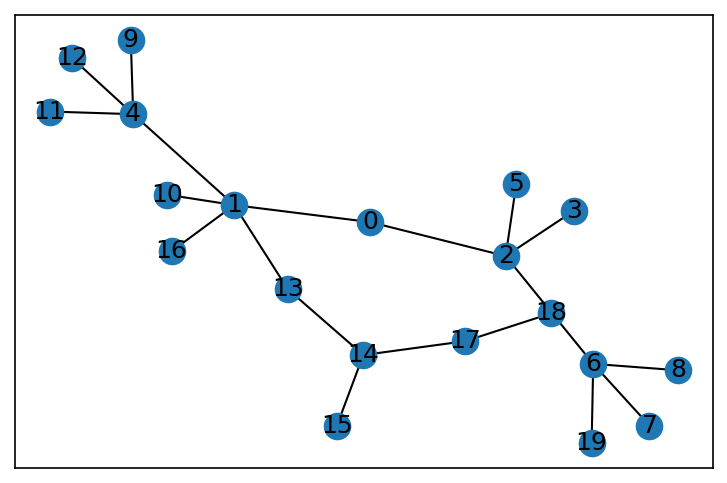

In [399]:
from networkx.generators.random_graphs import *
l = 20 # (int) – number of cliques
k = 1 # (int) – size of cliques
G = barabasi_albert_graph(l, k)
ccg_pos = nx.layout.spring_layout(G)
plt.figure(dpi =150)
nx.draw_networkx(G, node_size=150, pos=ccg_pos)
print('A sample barabasi albert graph with l = 20, k = 2')
plt.show()

In [397]:
def seir_network_simulation_barabasi_albert(N = 1000, 
                         beta = 0.8, 
                         gamma0 = 0.1, 
                         sigma = 0.5,
                         alpha = 0.001,
                         mu = 0.0001, 
                         T = 200,
                         delta = 0.9,
                         target = 1,
                         k = 3):
    G = barabasi_albert_graph(l, k)
    A = adjacency_matrix(G).toarray() # adjacency matrix of the graph
    A_hat = normalized_adjacency(A, symmetry = False)
    #N = 1000 # number of sub-population
    M = A_hat.shape[0] # number of sub-populations
    I0 = np.zeros(M) # np.random.randint(size = M, low=10, high = 30) #0
    I0[0] = 1
    R0 = np.zeros(M)  #0 
    E0 = np.zeros(M) #0 
    beta = 0.8 
    gamma = gamma0
    A = np.eye(M) * delta + A_hat * (1-delta)
    # Everyone else, S0, is susceptible to infection initially.
    # QE0, QI0 = np.zeros(M), np.zeros(M) #0, 0
    S0 = N - I0 - R0 - E0
    t = np.linspace(0, T, T)

    # The SIR model differential equations.
    def deriv(y, t, N, beta, gamma, sigma, mu, q, A):
        y = y.reshape(4, -1)

        S, E, I, R = y[0], y[1], y[2], y[3] # S, E, I, R: array with shape (M, )
        #print(S.shape,E,I,R)
        S = A.T.dot(S)
        E = A.T.dot(E)
        I = A.T.dot(I)
        R = A.T.dot(R)
        N = S + E + I + R
        gamma2 = gamma * (1+t*alpha)
        dSdt = mu * (N - S) - beta * S * I / N
        dEdt = beta * S * I / N - (mu + sigma) * E
        dIdt = sigma * E - (mu + gamma2) * I
        dRdt = gamma2 * I - mu * R
        return np.hstack([dSdt, dEdt, dIdt, dRdt])

    # Initial conditions vector
    y0 = np.hstack([S0, E0, I0,  R0])
    print('Input shape [should be %d]:'%(4*M), y0.shape)
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, sigma, mu, q, A))
    ret = ret.T
    print('Output shape [should be (%d, %d)]:'%(4*M, T), ret.shape)

    S = ret[ : M]
    E = ret[M : 2*M]
    I = ret[2*M : 3*M]
    R = ret[3*M : 4*M]
    
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure(facecolor='w', figsize =  [8,6], dpi = 100)
    ax = fig.add_subplot(111,  axisbelow=True)
    if target == "All":
        plt.plot(t, np.sum(S, axis = 0), 'b', alpha=0.6, lw=2.5, label='Susceptible')
        plt.plot(t, np.sum(E, axis = 0), 'purple', alpha=0.6, lw=2.5, label='Exposed')     
        plt.plot(t, np.sum(I, axis = 0), 'r', lw=2.5, label='Infected')
        plt.plot(t, np.sum(R, axis = 0), 'g', lw=2.5, label='Recovered')
        plt.title('Curve for all sub-populations')
    else:
        plt.plot(t, S[target], 'b', alpha=0.6, lw=2.5, label='Susceptible')
        plt.plot(t, E[target], 'purple', alpha=0.6, lw=2.5, label='Exposed')     
        plt.plot(t, I[target], 'r', lw=2.5, label='Infected')
        plt.plot(t, R[target], 'g', lw=2.5, label='Recovered')
        plt.title('Curve for sub-population %d'%target)
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number of people')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major',  c='grey',lw=1, ls=':')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    plt.show()

In [400]:
interact (seir_network_simulation_barabasi_albert
    , N=(1, 1000, 10)
    , beta=(0, 1, 0.05)
    , gamma0 = (0, 0.5, 0.01)
    , alpha = (0, 0.05, 0.001)
    , sigma = (0, 1, 0.05)
    , mu = (0, 0.01, 0.001)
    , T = (0, 300, 10)
    , delta = (0.6, 1, 0.05)
    , target = ["All"] + [i for i in range(l)]
    , k = (1, int(l/2), 1)
    );

interactive(children=(IntSlider(value=1000, description='N', max=1000, min=1, step=10), FloatSlider(value=0.8,…

From the above simulation, we find that with the increase of $k$, the corresponding peak time almost remains same, but the peak value increases significantly when $k$ is increased from 1 to 2 and 2 to 3. Then, the increase is not obvious. We explain such phenomenon as: at the first, the density of the Barabasi-Albert model increase very fast, and in this case and the spread of the virus among different regions will be weaker. In our real life, such 'edge' can be regarded as the transportstion tools (e.g. flights, trains), and by reducing these transportations, it will be useful to reduce the infection rate.

# Conclusion
From the above, we aim to simulate the spread of the disease via using ODE-based SEIR on community-level and network-level disease spread, and justify the effect of social distancing (quarantine) and reducing the transportation tools. We give detailed  analysis on several key parameter to better explain the role of several factors.